In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from keras import backend as k
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications import Xception
import tensorflow_addons as tfa
import cv2

In [2]:
birds = pd.read_csv('../data/birds.csv')

In [3]:
birds.head(5)

,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [4]:
train = birds[birds['data set'] == 'train']
test = birds[birds['data set'] == 'test']
val = birds[birds['data set'] == 'valid']

In [5]:
train.shape

(54652, 4)

In [6]:
test.shape

(1875, 4)

In [7]:
val.shape

(1875, 4)

In [39]:
test.head(5)

,class index,filepaths,labels,data set
54652,0,test/ABBOTTS BABBLER/1.jpg,ABBOTTS BABBLER,test
54653,0,test/ABBOTTS BABBLER/2.jpg,ABBOTTS BABBLER,test
54654,0,test/ABBOTTS BABBLER/3.jpg,ABBOTTS BABBLER,test
54655,0,test/ABBOTTS BABBLER/4.jpg,ABBOTTS BABBLER,test
54656,0,test/ABBOTTS BABBLER/5.jpg,ABBOTTS BABBLER,test


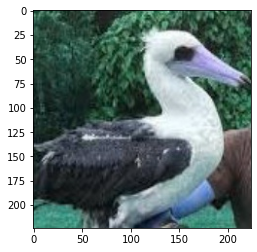

In [73]:
img = cv2.imread(f"../data/{birds['filepaths'][300]}")
plt.imshow(img)

In [68]:
BATCH_SIZE = 16
EPOCHS = 20
INPUT_SIZE = [128, 128]

In [40]:
datagen=ImageDataGenerator(rescale=1.0/255.0, 
                           shear_range=0.1, 
                           zoom_range=0.1, 
                           horizontal_flip=True, 
                           vertical_flip = True)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory="../data/",
    x_col="filepaths",
    y_col="labels",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=INPUT_SIZE,
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val,
    directory="../data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=INPUT_SIZE,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="../data/",
    x_col="filepaths",
    y_col="labels",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=INPUT_SIZE,
)

Found 54652 validated image filenames belonging to 375 classes.
Found 1875 validated image filenames belonging to 375 classes.
Found 1875 validated image filenames belonging to 375 classes.


In [48]:
# ModelCheckpoint callback is used to save only the best model out of all the epochs...
checkpoint = ModelCheckpoint(filepath="../models/resnet.h5", verbose=2, save_best_only=True)
vgg_checkpoint = ModelCheckpoint(filepath="../models/vgg16.h5", verbose=2, save_best_only=True)
incepV3_checkpoint = ModelCheckpoint(filepath="../models/inception.h5", verbose=2, save_best_only=True)
xcep_checkpoint = ModelCheckpoint(filepath="../models/Xception_v2.h5", verbose=2, save_best_only=True)


# EarlyStopping callback is used to stop the training when accuracy doesn't improve for 5 epochs...
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

callbacks = [early_stop, checkpoint]
vgg_callbacks = [early_stop, vgg_checkpoint]
incepV3_callbacks = [early_stop, incepV3_checkpoint]
xcep_callbacks = [early_stop, xcep_checkpoint]

In [12]:
def plotter(history, model):
    fig, axes = plt.subplots(1, 2, figsize = (10, 5)) # fig of 1 row and 2 cols with 10x5 size...
    # In First column of figure, plotting accuracy and val accuracy from trained model object(history)...
    axes[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy') 
    axes[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
    axes[0].set_xlabel('Epochs', fontsize = 14)
    axes[0].set_ylabel('Accuracy',fontsize = 14)
    axes[0].set_title(f"{model} Accuracy Training vs Testing", fontsize = 14)
    axes[0].legend(loc = 'best') # Location of the legend, whereever is more empty space put legent there (loc= 'best')...
    # In Second column of figure, plotting accuracy and val accuracy from trained model object(history)...
    axes[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
    axes[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
    axes[1].set_xlabel('Epochs', fontsize = 14)
    axes[1].set_ylabel('Loss',fontsize = 14)
    axes[1].set_title(f"{model} Loss Training vs Testing", fontsize = 14)
    axes[1].legend(loc = 'best')
    plt.show()

In [18]:
# input of size 256x256x3... hight x width = 256 x 256, number of channels = 3...
input = Input(name = 'img_input', shape=INPUT_SIZE+[3])

In [13]:
# def network(base_model, input):
    
#     # Removes the values in the graph(network connections) but do not delete the graph itself... helps in RAM cleaning...
#     tf.keras.backend.clear_session() 

#     # Making Base model layers as non-trainable...
#     for layer in base_model.layers:
#       layer.trainable = False

#     input_layer = base_model(input) # defining input layer...


#     # Functional API of keras is used for this network...

#     # Convolution layer with 32 filters of size 3x3 and stride = 1x1, activation function used is ReLU and "valid" padding to keep the input and output size same...
#     # he normal kernel initializer is used as it performs well with non-linear activation functions like ReLU... 
#     conv = Conv2D(filters = 32, kernel_size = (7, 7), strides = (1, 1), padding = 'valid', activation = 'relu', 
#               kernel_initializer = tf.keras.initializers.he_normal())(input_layer)
#     pool = GlobalAveragePooling2D()(conv) # the pool size is set to the input size and it outputs the average of the pool...
#     d1 = Dense(units = 64, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal())(pool)
#     drop1 = Dropout(0.5)(d1) # dropout was used to deactivate some of the nodes to avoid overfitting...
#     d2 = Dense(units = 128, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal())(drop1)
#     bn = BatchNormalization()(d2) # batch normalization was used normalize weights batch wise and in turn reduce the chances of overfitting...
#     drop2 = Dropout(0.2)(bn)
#     d3 = Dense(units = 64, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal())(drop2)
#     Out = Dense(units = 375, activation = 'softmax', kernel_initializer = tf.keras.initializers.he_normal())(d3)
#     model = tf.keras.Model(input, Out) 
    
#     return model

In [54]:
def network(base_model, input):
    
    # Removes the values in the graph(network connections) but do not delete the graph itself... helps in RAM cleaning...
    tf.keras.backend.clear_session() 

    # Making Base model layers as non-trainable...
    for i in base_model.layers[:-15]:
        i.trainable=False

    input_layer = base_model(input, training=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten()) 
    model.add(Activation('relu'))
    model.add(Dense(375)) 
    model.add(Activation('softmax'))
    


#     input_layer = base_model(input) # defining input layer...


#     # Functional API of keras is used for this network...

#     # Convolution layer with 32 filters of size 3x3 and stride = 1x1, activation function used is ReLU and "valid" padding to keep the input and output size same...
#     # he normal kernel initializer is used as it performs well with non-linear activation functions like ReLU... 
    
#     model = Sequential()
#     model.add(base_model)
# #     model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1, 1), padding = 'valid', activation = 'relu', 
# #               kernel_initializer = tf.keras.initializers.he_normal()))
#     model.add(Flatten())
#     model.add(Dense(units = 1024, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal()))
#     model.add(Dropout(0.2))
#     model.add(Dense(units = 512, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal()))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(Dense(units = 512, activation = 'relu', kernel_initializer = tf.keras.initializers.he_normal()))
#     model.add(Dense(units = 375, activation = 'softmax', kernel_initializer = tf.keras.initializers.he_normal()))
    
    return model

In [55]:
# Loading weights of the ResNet101 pre-trained model without including top layers... imagenet is a dataset on which ResNet101 was trained...
resnet_model = ResNet101(input_tensor = input, include_top=False, weights="imagenet")

res_model = network(resnet_model, input)

adam = Adam(learning_rate=0.0001) # ADAM optimizer was used to reach the optimal weights...
res_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(375)])


# Fitting/training model...
res_history = res_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=callbacks,
    epochs = EPOCHS, 
    validation_data = valid_generator)

Epoch 1/20
1608/1607 [==============================] - ETA: 0s - loss: 5.3944 - accuracy: 0.0470 - f1_score: 0.0397
Epoch 00001: val_loss improved from inf to 5.00828, saving model to ../models\resnet.h5
1607/1607 [==============================] - 446s 275ms/step - loss: 5.3944 - accuracy: 0.0470 - f1_score: 0.0397 - val_loss: 5.0083 - val_accuracy: 0.0816 - val_f1_score: 0.0598
Epoch 2/20
1608/1607 [==============================] - ETA: 0s - loss: 4.6109 - accuracy: 0.1150 - f1_score: 0.1021
Epoch 00002: val_loss improved from 5.00828 to 4.91834, saving model to ../models\resnet.h5
1607/1607 [==============================] - 446s 277ms/step - loss: 4.6109 - accuracy: 0.1150 - f1_score: 0.1021 - val_loss: 4.9183 - val_accuracy: 0.1029 - val_f1_score: 0.0838
Epoch 3/20
1608/1607 [==============================] - ETA: 0s - loss: 4.1806 - accuracy: 0.1684 - f1_score: 0.1563
Epoch 00003: val_loss improved from 4.91834 to 4.26487, saving model to ../models\resnet.h5
1607/1607 [========

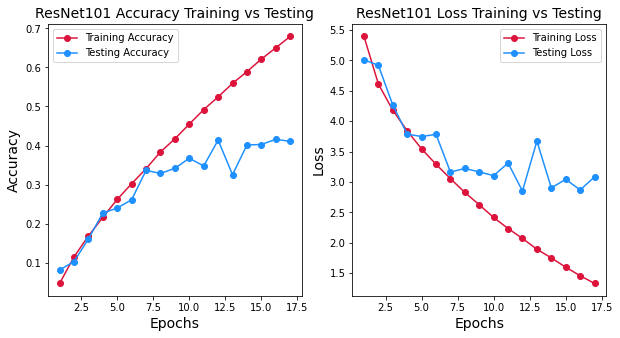

In [56]:
plotter(res_history, "ResNet101")

In [63]:
res_model.evaluate(test_generator)

56/56 [==============================] - 16s 255ms/step - loss: 3.3237 - accuracy: 0.3760 - f1_score: 0.3554


[3.323721170425415,
 0.37599998712539673,
 array([0.        , 0.        , 0.2857143 , 0.6666667 , 0.        ,
        0.23529413, 0.2857143 , 0.40000004, 0.        , 0.15384616,
        0.        , 0.3333333 , 0.6666667 , 0.40000004, 0.6       ,
        0.53333336, 0.22222224, 0.3333333 , 0.3333333 , 0.5714286 ,
        0.3333333 , 0.5714286 , 0.2857143 , 0.75      , 0.22222224,
        0.46153846, 0.25      , 0.25      , 0.3333333 , 0.        ,
        0.71428573, 0.5714286 , 0.125     , 0.        , 0.        ,
        0.        , 0.5       , 0.5714286 , 0.17391303, 0.7692308 ,
        0.18181819, 0.36363637, 0.        , 0.72727275, 0.3703704 ,
        0.75      , 0.5714286 , 0.5714286 , 0.3333333 , 0.2857143 ,
        0.5       , 0.        , 0.36363637, 0.6666667 , 0.46153846,
        0.5714286 , 0.3333333 , 0.57142854, 0.40000004, 0.3333333 ,
        0.36363634, 0.        , 0.5714286 , 0.53333336, 0.6666667 ,
        0.3333333 , 0.        , 0.5714286 , 0.6666667 , 0.5714286 ,
      

In [ ]:
# Loading weights of the vgg16 pre-trained model without including top layers... imagenet is a dataset on which vgg16 was trained...
vgg16_model = VGG16(input_tensor = input, include_top=False, weights="imagenet")

vgg_model = network(vgg16_model, input)

adam = Adam(learning_rate=0.0001) # ADAM optimizer was used to reach the optimal weights...
vgg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy',  tfa.metrics.F1Score(375)])


# Fitting/training model...
vgg_history = vgg_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=vgg_checkpoint,
    epochs = EPOCHS, 
    validation_data = valid_generator)

In [ ]:
plotter(vgg_history, "VGG16")

In [ ]:
vgg_results = vgg_model.evaluate(test_generator)
print(f"Accuracy of Inception v3 transfer learning model is: {vgg_results}")

In [ ]:
# Loading weights of the InceptionV3 pre-trained model without including top layers... imagenet is a dataset on which InceptionV3 was trained...
inception_model = InceptionV3(input_tensor = input, include_top=False, weights="imagenet")

incepV3_model = network(inception_model, input)

adam = Adam(learning_rate=0.001) # ADAM optimizer was used to reach the optimal weights...
incepV3_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(375)])


# Fitting/training model...
incepV3_history = incepV3_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=incepV3_checkpoint,
    epochs = 50, 
    validation_data = valid_generator)

In [ ]:
plotter(incepV3_history, "InceptionV3")

In [ ]:
incepV3_results = incepV3_model.evaluate(test_generator)
print(f"Accuracy of Inception v3 transfer learning model is: {incepV3_results}")

In [49]:
base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

for i in base_model.layers[:-15]:
    i.trainable=False


input_layer = base_model(input, training=False)

Xception_model = Sequential()
Xception_model.add(base_model)
Xception_model.add(Flatten()) 
Xception_model.add(Activation('relu'))
Xception_model.add(Dense(375)) 
Xception_model.add(Activation('softmax'))


In [50]:
adam = Adam(learning_rate=0.0001) # ADAM optimizer was used to reach the optimal weights...
Xception_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(375)])


# Fitting/training model...
Xception_history = Xception_model.fit(
    train_generator, 
    steps_per_epoch = len(train) / BATCH_SIZE, # number of steps in each epoch...
    callbacks=xcep_callbacks,
    epochs = EPOCHS, 
    validation_data = valid_generator)

Epoch 1/20
1608/1607 [==============================] - ETA: 0s - loss: 1.4531 - accuracy: 0.6741 - f1_score: 0.6739
Epoch 00001: val_loss improved from inf to 0.37008, saving model to ../models\Xception_v2.h5
1607/1607 [==============================] - 559s 347ms/step - loss: 1.4531 - accuracy: 0.6741 - f1_score: 0.6739 - val_loss: 0.3701 - val_accuracy: 0.8864 - val_f1_score: 0.8829
Epoch 2/20
1608/1607 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.8774 - f1_score: 0.8765
Epoch 00002: val_loss improved from 0.37008 to 0.31346, saving model to ../models\Xception_v2.h5
1607/1607 [==============================] - 418s 260ms/step - loss: 0.4493 - accuracy: 0.8774 - f1_score: 0.8765 - val_loss: 0.3135 - val_accuracy: 0.9109 - val_f1_score: 0.9096
Epoch 3/20
1608/1607 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.9176 - f1_score: 0.9170
Epoch 00003: val_loss improved from 0.31346 to 0.25540, saving model to ../models\Xception_v2.h5
1607

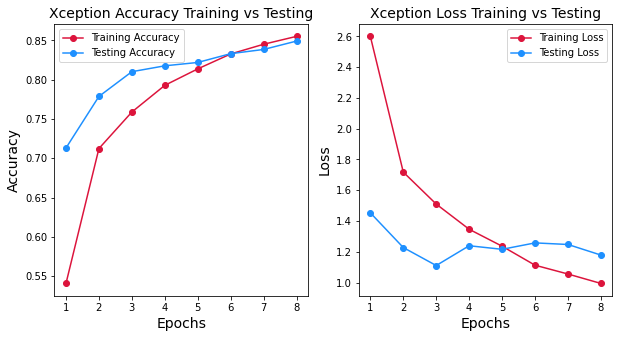

In [32]:
plotter(Xception_history, "Xception")

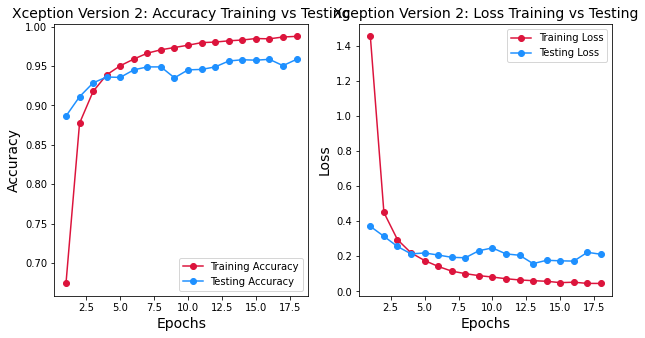

In [51]:
plotter(Xception_history, "Xception Version 2:")

In [52]:
# xcep_model = load_model('../models/Xception.h5')
Xception_model.evaluate(test_generator)

56/56 [==============================] - 8s 145ms/step - loss: 0.1180 - accuracy: 0.9707 - f1_score: 0.9698
